In [1]:
import os, sys, wave, struct
import pyaudio
import numpy as np
import pandas as pd
import librosa as lib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython

from copy import deepcopy
from math import ceil, exp, atan, pi, cos, sin
from scipy.io.wavfile import write
#import scipy.io.wavfile
from scipy.linalg import hankel
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import pylab as p
#import matplotlib.axes3d as p3
import mpl_toolkits.mplot3d.axes3d as p3

# Useful functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')

def plot_sound(data, times,xlim1,xlim2,name='default_name', save=False,w=20,h=10, lw = 3):
    plt.figure(figsize=(w, h))
    plt.plot(times,x.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    
def read_values(filename):
    wave_file = wave.open(filename, 'r')
    nframes = wave_file.getnframes()
    nchannels = wave_file.getnchannels()
    sampling_frequency = wave_file.getframerate()
    T = nframes / float(sampling_frequency)
    read_frames = wave_file.readframes(nframes)
    wave_file.close()
    data = struct.unpack("%dh" %  nchannels*nframes, read_frames)
    
    data_per_channel = [data[offset::nchannels] for offset in range(nchannels)]
    return T, np.array(data_per_channel), nframes, nchannels, sampling_frequency

In [3]:
def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()

In [4]:
def Synthesis(N,delta,f,a,phi,RSB=False):
    t = range(N)
    logz = delta + 1j*2*np.pi*f
    alpha = a*np.exp(1j*phi)
    x = np.sum(np.outer(alpha, np.ones(N))*np.exp(np.outer(logz,t)), axis=0)
    if RSB == False: 
        s = x
    else: 
        Ex = np.real(np.sum(np.abs(x)**2))/N
        b = np.random.normal(size=N) + 1j*np.random.normal(size=N)
        Eb = np.real(np.sum(np.abs(b)**2))/N
        b = b*np.sqrt(Ex/Eb)*10**(-RSB/20)
        s = x+b    
    return s

# Open audio file

In [5]:
wavefile = load_sound('ClocheB.WAV')
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=8000, nframes=99414, comptype='NONE', compname='not compressed')


In [6]:
IPython.display.Audio('ClocheB.WAV')

In [7]:
T, data, nframes, nchannels, sampling_frequency = read_values('ClocheA.WAV')
Fs = int(wavefile.getframerate())
x = np.array(data)
num_samples = int(wavefile.getnframes())

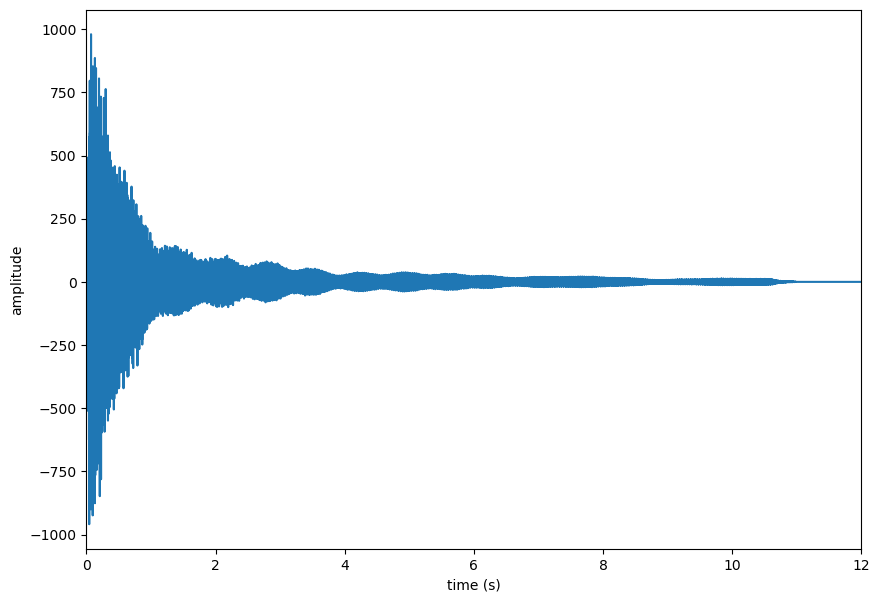

In [8]:
len_x = x.shape[1]
timestep = 1/(float(Fs))
times = np.arange(len_x)*timestep # int(len_x/6)
plot_sound(x.reshape(len_x), times,0,12,w=10,h=7)

In [9]:
write('new_bell.wav', Fs, np.array(x.reshape(len_x), dtype=np.int16)) # to write a new wave file

# 3. Synthetic signal

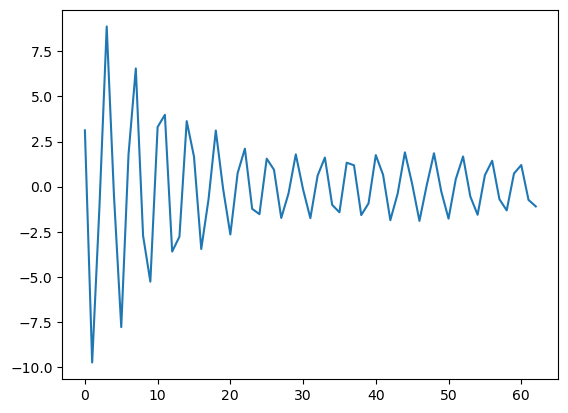

In [10]:
np.random.seed(0)
N = 63
f = np.array([1/4, 1/4 + 1/N])
a = np.array([1, 10])
delta = np.array([0, -0.05])
phi = np.random.random(2)*2*np.pi - np.pi
x = Synthesis(N, delta, f, a, phi)
plt.plot(np.real(x))
plt.show()

## 3.1. Spectral analysis by Fourier transform

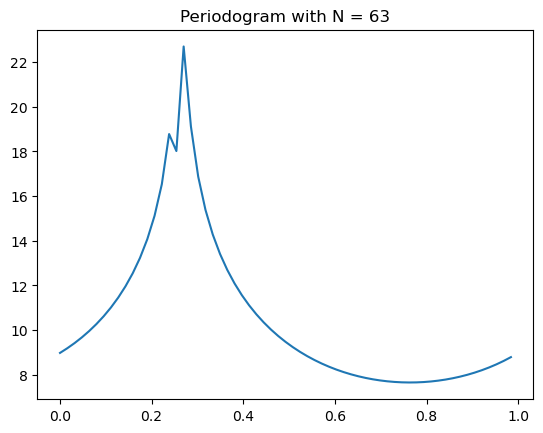

In [11]:
X = np.fft.fft(x, 63)
plt.plot(np.linspace(0, 1, len(X), endpoint=False), 10*np.log10(np.abs(X)))
plt.title("Periodogram with N = "+str(X.size))
plt.show()

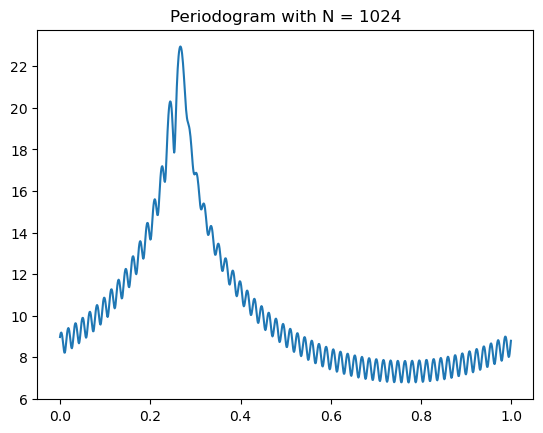

In [12]:
X_zero_padding = np.fft.fft(x, 1024)
plt.plot(np.linspace(0, 1, len(X_zero_padding), endpoint=False), 10*np.log10(np.abs(X_zero_padding)))
plt.title("Periodogram with N = "+str(X_zero_padding.size))
plt.show()

We observe that the periodogram does not achieve the separation of the frequencies as they are separated by an interval which is the limit of the resolution of Fourier analysis.

## 3.2. High resolution methods

### 3.2.1. ESPRIT method

#### 3. Estimation of the frequencies and damping factors

In [13]:
n = 32
K = 2
def ESPRIT(x, n, K, N):
    l = N - n + 1
    X_hankel = np.matrix(hankel(x[:n], x[n-1:]))
    R_xx_hat = 1 / l * X_hankel @ X_hankel.H
    U1, Lambda, U2 = np.linalg.svd(R_xx_hat)
    W = U1[:,:K]
    W_low = W[:-1]
    W_up = W[1:]
    Phi = np.matrix(np.linalg.pinv(W_low) @ W_up)
    Z, v = np.linalg.eig(Phi)
    delta = np.log(np.abs(Z))
    f = 1/(2*np.pi)*np.angle(Z)
    return delta, f

#### 4. Estimation of the amplitudes and phases

In [14]:
def LeastSquares(x, delta, f, N):
    
    line = np.matrix(np.arange(N)).T
    column = np.matrix(delta + 2*np.pi*f*1j)
    
    V_N = np.exp(line @ column)
    alpha = np.linalg.pinv(V_N) @ x
    a = np.abs(alpha)
    phi = np.angle(alpha)
    return a, phi

#### 5. Application to synthetic signals



In [15]:
delta_est, f_est = ESPRIT(x, n, K, N)
a_est, phi_est = LeastSquares(x, delta_est, f_est, N)
print("a = ", a_est)
print("phi = ", phi_est)
print("delta = ", delta_est)
print("f = ", f_est)

a =  [[10.  1.]]
phi =  [[1.35207467 0.30670429]]
delta =  [-5.00000000e-02 -1.11022302e-16]
f =  [0.26587302 0.25      ]


We recover the original frequencies, amplitudes and decays, with a permutation due to the SVD which sorts the eigenvalues by decreasing absolute values.

C:\Users\Delhio\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


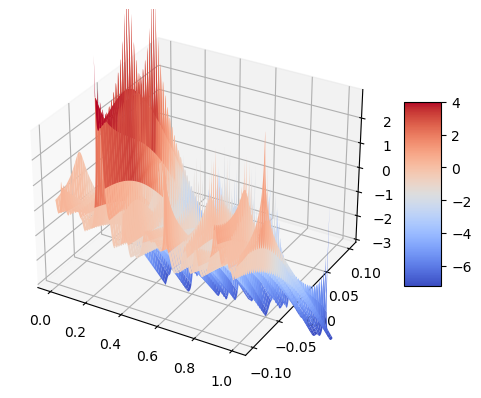

In [16]:
def compute_v_n(z,n):
    return np.matrix([z**i for i in range (n)]).T


def MUSIC(x, n, K):
    l = N - n + 1
    X_hankel = np.matrix(hankel(x[:n], x[n-1:]))
    R_xx_hat = 1 / l * X_hankel @ X_hankel.H
    U1, Lambda, U2 = np.linalg.svd(R_xx_hat)
    W_ortho = U1[:,K:]
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # Make data.
    F = np.arange(0, 1, 0.001)
    D = np.arange(-0.1, 0.1, 0.0002)
    F, D = np.meshgrid(F, D)
    R = np.exp(D + 2*1j*np.pi*F)
    Z = np.log(np.array([[1/((W_ortho.H @ compute_v_n(r, n)).T@((W_ortho.H @ compute_v_n(r, n)))) for r in R[i]] for i in range (len(R))]))
    Z=Z.reshape([1000,1000])

    # Plot the surface.
    surf = ax.plot_surface(F, D, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=True)

    # Customize the z axis.
    ax.set_zlim(-3, 3)
    ax.set_zticks(np.arange(-3,3,1))
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
MUSIC(x, n, K)

We observe the presence of the two peaks, colored in dark red.

# 4. Audio signals

### 4.1. Spectral analysis by Fourier transform

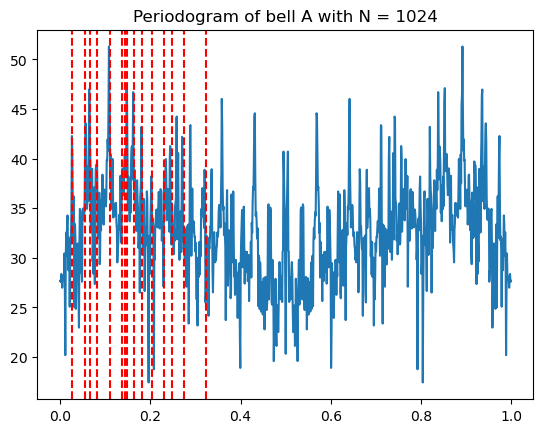

In [17]:
data_path = os.getcwd()
filename = 'ClocheA.wav'
sound = os.path.join(data_path, filename)  
wavefile = load_sound(sound)    
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x_A = np.array(data)
X_A = np.fft.fft(x_A, 1024)

x=0.055
plt.plot(np.linspace(0, 1, len(X_A), endpoint=False), 10*np.log10(np.abs(X_A)))
plt.axvline(x=0.5*x, color='r', linestyle = '--')
plt.axvline(x=x, color='r', linestyle = '--')
plt.axvline(x=1.2*x, color='r', linestyle = '--')
plt.axvline(x=1.5*x, color='r', linestyle = '--')
plt.axvline(x=2*x, color='r', linestyle = '--')
plt.axvline(x=2.5*x, color='r', linestyle = '--')
plt.axvline(x=2.6*x, color='r', linestyle = '--')
plt.axvline(x=2.7*x, color='r', linestyle = '--')
plt.axvline(x=3*x, color='r', linestyle = '--')
plt.axvline(x=3.3*x, color='r', linestyle = '--')
plt.axvline(x=3.7*x, color='r', linestyle = '--')
plt.axvline(x=4.2*x, color='r', linestyle = '--')
plt.axvline(x=4.5*x, color='r', linestyle = '--')
plt.axvline(x=5*x, color='r', linestyle = '--')
plt.axvline(x=5.9*x, color='r', linestyle = '--')
plt.title("Periodogram of bell A with N = "+str(X_A.size))
plt.show()

In [18]:
N = 1535
n = 512
K = 54
x_A_extracted = x_A[10000:10000+N]
delta_est2, f_est2 = ESPRIT(x_A_extracted, n, K, N)
a_est2, phi_est2 = LeastSquares(x_A_extracted, delta_est2, f_est2, N)
print("a = ", a_est2)
print("phi = ", phi_est2)
print("delta = ", delta_est2)
print("f = ", f_est2)

a =  [[ 0.17262128  0.17262128  0.15379346  0.15379346  0.14423048  0.14423048
   1.06037698  1.06037698  0.29943877  0.29943877  0.45622965  0.45622965
   1.24535663  1.24535663  0.20078005  0.20078005  0.54894426  0.54894426
   0.08461336  0.08461336  0.31355059  0.31355059  0.18550675  0.18550675
   0.22175233  0.22175233  1.1298397   1.1298397   5.49357909  5.49357909
   0.07317618  0.07317618 25.13847404 25.13847404  7.89627255  7.89627255
  26.81845347 26.81845347  3.15381661  3.15381661  8.15935797  8.15935797
   0.73580819  0.73580819  0.98627826  0.98627826  3.41048729  3.41048729
   0.06114699  0.06114699  3.76788755  3.76788755  4.09005356  4.09005356]]
phi =  [[ 2.01181626 -2.01181626  1.65097898 -1.65097898  2.84215389 -2.84215389
  -1.0981103   1.0981103  -1.22860318  1.22860318  0.81076871 -0.81076871
  -1.63272885  1.63272885 -2.32545088  2.32545088  0.82203923 -0.82203923
   1.8459081  -1.8459081  -0.25547525  0.25547525  2.11504528 -2.11504528
   1.74303845 -1.7430384

We must make sure that the damping factors are negative, so let us ensure that we have this property manually.

In [19]:
a_est2 = np.asarray(a_est2).reshape(K)
phi_est2 = np.asarray(phi_est2).reshape(K)
for i in range(len(delta_est2)):
    if delta_est2[i]>=0:
        delta_est2[i] = -delta_est2[i]

Let us synthesize the signal thanks to the parameters we estimated thanks to the ESPRIT method.

In [20]:
x_new = Synthesis(20*N, delta_est2, f_est2, a_est2, phi_est2)

We add a multiplication constant to the signal so that the sound we will hear is loud enough.

In [21]:
x_reamplified = 20 * x_new

Then, let us write a new WAV file that contains our synthesized signal, and let us listen to it.

In [22]:
write('new_bell.wav', Fs, np.array(x_reamplified, dtype=np.int16))
data_path = os.getcwd()
filename = 'new_bell.wav'
sound = os.path.join(data_path, filename)
wavefile = lib.load(sound)
play_sound(sound)

C:\Users\Delhio\AppData\Local\Temp\ipykernel_16632\1868996694.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  write('new_bell.wav', Fs, np.array(x_reamplified, dtype=np.int16))


The obtained sound is similar to the original one, which confirms the accuracy of HR methods like ESPRIT.